In [1]:
import squidpy as sq
import scanpy as sc
import pandas as pd 
import numpy as np 
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
from adipo_finder import utils as seg_utils
from adipo_finder import segmentation as seg
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import adipo_finder.new_adipofinder_code as nac
from skimage import measure, morphology, segmentation, feature
from scipy.ndimage import distance_transform_edt, label, binary_dilation
from sklearn.datasets import make_blobs
import torch


/home/jgustafs/miniconda3/envs/adipo_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/jgustafs/miniconda3/envs/adipo_env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
#get ground truth ids
import os
import glob
ground_truth_path = "../../../data/Manual_adipocyte_segmentation/"
old_pred_path = "../../../old_predictions/"
new_pred_path = "../../../new_predictions/"

# find all files ending with " step 1.tif"
files = glob.glob(os.path.join(ground_truth_path, "* step 3.tif"))

# extract IDs (everything before " step 1.tif")
gt_ids = [os.path.basename(f).replace(" step 3.tif", "") for f in files]

print(gt_ids)

['ROI001_02454_ROI_1', 'ROI001_026859_ROI_1', 'ROI001_08147_ROI_1', 'ROI001_31479_ROI_1', 'ROI001_40423_ROI_2', 'ROI001_44243_ROI_1', 'ROI001_50286_ROI_1', 'ROI001_62626_ROI_1', 'ROI001_70736_ROI_1', 'ROI001_J33533_ROI_1', 'ROI002_40900_ROI_1', 'ROI002_45504_ROI_1', 'ROI002_74014_ROI_1', 'ROI003_37912_ROI_1', 'ROI004_55218_ROI_1']


In [3]:
print(f"ground truth samples: {len(gt_ids)}")

ground truth samples: 15


In [4]:
from PIL import Image
pred_images_old = []
pred_images_new = []
ground_truth_images = []
for id in gt_ids:
    pred_images_old.append(np.array(Image.open(old_pred_path + id + " pred_adipocytes.png")))
    pred_images_new.append(np.array(Image.open(new_pred_path + id + " pred_adipocytes.png")))
    ground_truth_images.append(np.array(Image.open(ground_truth_path + id + " step 4.png")))
    

In [5]:
len(pred_images_new)

15

In [6]:
old_metrics = []
new_metrics = []
for i,gt_id in enumerate(gt_ids):
    old_metrics.append(nac.evaluate_segmentation(pred_images_old[i], ground_truth_images[i], overlap_threshold=0.5))
    new_metrics.append(nac.evaluate_segmentation(pred_images_new[i], ground_truth_images[i], overlap_threshold=0.5))



In [8]:
#tests

gt = np.array([
    [0,1,1,0],
    [0,1,1,0],
    [0,0,0,0],
    [0,0,0,0]
])

pred = np.array([
    [0,1,1,0],
    [0,1,1,0],
    [0,0,0,0],
    [0,0,0,0]
])

nac.evaluate_segmentation(pred, gt, overlap_threshold = 0.5) #looks ok, 1 TP

{'TP': [1],
 'FP': [],
 'FN': [],
 'TP_labels_in_GT': [1],
 'FP_best_GT': [],
 'FN_labels_in_GT': [],
 'tp_coverage': [1.0],
 'fp_coverage': [],
 'fn_coverage': []}

In [9]:
gt = np.array([
    [0,1,1,0],
    [0,1,1,0],
    [0,0,0,0],
    [0,0,0,0]
])

pred = np.array([
    [0,1,0,0],
    [0,1,0,0],
    [0,2,0,0],
    [0,2,0,0]
])

print(nac.evaluate_segmentation(pred, gt, overlap_threshold=0.6)) #looks ok, 2 FP, 1 FN
print(nac.evaluate_segmentation(pred, gt, overlap_threshold=0.4)) #looks ok, 1 TP, 1 FP, 0 FN, one false


{'TP': [], 'FP': [1, 2], 'FN': [None], 'TP_labels_in_GT': [], 'FP_best_GT': [1, None], 'FN_labels_in_GT': [1], 'tp_coverage': [], 'fp_coverage': [0.5, 0.0], 'fn_coverage': [0.0]}
{'TP': [1], 'FP': [2], 'FN': [], 'TP_labels_in_GT': [1], 'FP_best_GT': [None], 'FN_labels_in_GT': [], 'tp_coverage': [0.5], 'fp_coverage': [0.0], 'fn_coverage': []}


In [10]:
#we need the model to figure out which samples were training, validation, and test
model, train_ids, val_ids, test_ids = nac.load_model("../data/trained_model_main.pth")

In [11]:
len(train_ids)

9

In [12]:
len(val_ids)

3

In [13]:
len(test_ids)

3

In [14]:
eval_df = nac.get_pred_eval_dataframe(gt_ids, old_metrics, new_metrics, train_ids, val_ids, test_ids)
eval_df

,gt_id,split,P_old,R_old,F1_old,P_new,R_new,F1_new
0,ROI001_02454_ROI_1,test,0.614458,0.281768,0.386364,0.491018,0.906077,0.636893
1,ROI001_026859_ROI_1,train,0.558140,0.185328,0.278261,0.509847,0.899614,0.650838
2,ROI001_08147_ROI_1,train,0.514851,0.257426,0.343234,0.500000,0.831683,0.624535
3,ROI001_31479_ROI_1,val,0.709091,0.291045,0.412698,0.608939,0.813433,0.696486
4,ROI001_40423_ROI_2,train,0.674157,0.355030,0.465116,0.685567,0.786982,0.732782
5,ROI001_44243_ROI_1,train,0.611111,0.257812,0.362637,0.743802,0.703125,0.722892
6,ROI001_50286_ROI_1,train,0.436620,0.196203,0.270742,0.367816,0.810127,0.505929
7,ROI001_62626_ROI_1,train,0.636364,0.051471,0.095238,0.781022,0.786765,0.783883
8,ROI001_70736_ROI_1,train,0.718750,0.232323,0.351145,0.675362,0.784512,0.725857
9,ROI001_J33533_ROI_1,test,0.500000,0.320755,0.390805,0.490000,0.616352,0.545961


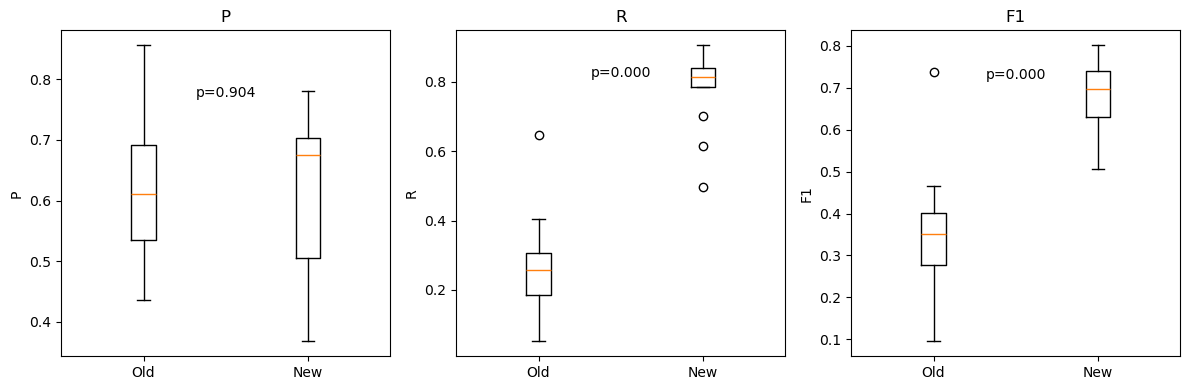

In [15]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

metrics = ["P", "R", "F1"]

plt.figure(figsize=(12, 4))

for i, m in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    
    # Data for boxplot
    data_old = eval_df[f"{m}_old"]
    data_new = eval_df[f"{m}_new"]
    
    plt.boxplot([data_old, data_new], labels=["Old", "New"])
    plt.title(m)
    plt.ylabel(m)
    
    # Paired t-test
    t_stat, p_val = ttest_rel(data_old, data_new)
    plt.text(1.5, max(data_old.max(), data_new.max())*0.9, f"p={p_val:.3f}",
             ha='center', fontsize=10)
    
plt.tight_layout()
plt.show()


In [16]:
#export to file
eval_df.to_csv("../../../evaluation_old_vs_new.txt", sep='\t', index=False)

In [17]:
#this is just for reloading the new_adipofinder_code in case it has been modified,
#to aviod having to restart the notebook
import importlib
import adipo_finder.new_adipofinder_code as nac

importlib.reload(nac)

<module 'adipo_finder.new_adipofinder_code' from '/mnt/d/Code/Projects/adipocyte_finder/adipo_finder/adipo_finder/new_adipofinder_code.py'>